In [79]:
import torch
from torch import nn
from torchinfo import summary

def num_parameters(m):
    return sum([p.numel() for p in m.parameters()])

In [80]:
dk, m, n = 3, 16, 32
print(f"Expected number of parameters: {m * dk * dk * n}")
conv1 = nn.Conv2d(in_channels=m, out_channels=n, kernel_size=dk, padding=dk-2, stride=1, bias=False)
print(f"Actual number of parameters: {num_parameters(conv1)}")

Expected number of parameters: 4608
Actual number of parameters: 4608


In [81]:
h, w = 128, 128
print(f"Expected total multiplies: {m * dk * dk * h * w * n}")
s1 = summary(conv1, input_size=(1, m, h, w))
print(f"Actual multiplies: {s1.total_mult_adds}")
print(s1)

Expected total multiplies: 75497472
Actual multiplies: 75497472
Layer (type:depth-idx)                   Output Shape              Param #
Conv2d                                   [1, 32, 128, 128]         4,608
Total params: 4,608
Trainable params: 4,608
Non-trainable params: 0
Total mult-adds (M): 75.50
Input size (MB): 1.05
Forward/backward pass size (MB): 4.19
Params size (MB): 0.02
Estimated Total Size (MB): 5.26


In [82]:
class DepthwiseSeparableConv(nn.Sequential):
    def __init__(self, chin, chout, dk):
        super().__init__(
            # Depthwise convolution
            nn.Conv2d(chin, chin, kernel_size=dk, stride=1, padding=dk-2, bias=False, groups=chin),
            # Pointwise convolution
            nn.Conv2d(chin, chout, kernel_size=1, bias=False),
        )

conv2 = DepthwiseSeparableConv(chin=m, chout=n, dk=dk)
print(f"Expected number of parameters: {m * dk * dk + m * 1 * 1 * n}")
print(f"Actual number of parameters: {num_parameters(conv2)}")

Expected number of parameters: 656
Actual number of parameters: 656


In [83]:
print(f"Expected total multiplies: {m * dk * dk * h * w + m * 1 * 1 * h * w * n}")
s2 = summary(conv2, input_size=(1, m, h, w))
print(f"Actual multiplies: {s2.total_mult_adds}")
print(s2)

Expected total multiplies: 10747904
Actual multiplies: 10747904
Layer (type:depth-idx)                   Output Shape              Param #
DepthwiseSeparableConv                   [1, 32, 128, 128]         --
├─Conv2d: 1-1                            [1, 16, 128, 128]         144
├─Conv2d: 1-2                            [1, 32, 128, 128]         512
Total params: 656
Trainable params: 656
Non-trainable params: 0
Total mult-adds (M): 10.75
Input size (MB): 1.05
Forward/backward pass size (MB): 6.29
Params size (MB): 0.00
Estimated Total Size (MB): 7.34


In [84]:
import pandas as pd

def get_layer_stats(h, w, channels, num_layers):
    d = {
        "height": [],
        "width": [],
        "channels": [],
        "RC-parameters": [],
        "RC-mult-adds": [],
        "DSC-parameters": [],
        "DSC-mult-adds": [],
    }
    for i in range(0, num_layers):
        _div = 1 << i
        _h, _w, _channels = h // _div, w // _div, channels * _div
        d["height"].append(_h)
        d["width"].append(_w)
        d["channels"].append(_channels)
        conv1 = nn.Conv2d(in_channels=_channels, out_channels=_channels * 2, kernel_size=3, padding=1, stride=1, bias=False)
        conv2 = DepthwiseSeparableConv(chin=_channels, chout=_channels * 2, dk=3)
        s1, s2 = summary(conv1, input_size=(1, _channels, 128, 128)), summary(conv2, input_size=(1, _channels, 128, 128))
        d["RC-parameters"].append(s1.trainable_params)
        d["DSC-parameters"].append(s2.trainable_params)
        d["RC-mult-adds"].append(s1.total_mult_adds)
        d["DSC-mult-adds"].append(s2.total_mult_adds)
    # end for
    df = pd.DataFrame(d)
    df["DSC/RC-parameters"] = df["DSC-parameters"] / df["RC-parameters"]
    df["DSC/RC-mult-adds"] = df["DSC-mult-adds"] / df["RC-mult-adds"]
    return df
# end def

df = get_layer_stats(128, 128, 64, 4)
df

,height,width,channels,RC-parameters,RC-mult-adds,DSC-parameters,DSC-mult-adds,DSC/RC-parameters,DSC/RC-mult-adds
0,128,128,64,73728,1207959552,8768,143654912,0.118924,0.118924
1,64,64,128,294912,4831838208,33920,555745280,0.115017,0.115017
2,32,32,256,1179648,19327352832,133376,2185232384,0.113064,0.113064
3,16,16,512,4718592,77309411328,528896,8665432064,0.112088,0.112088


In [85]:
from matplotlib import pyplot as plt

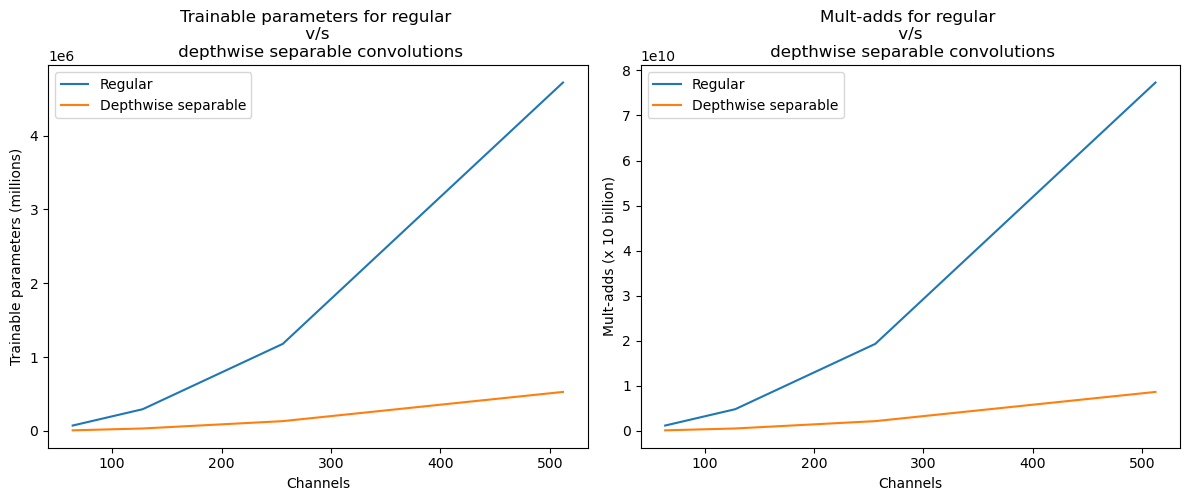

In [86]:
fig = plt.figure(figsize=(12, 5.11))

plt.subplot(1, 2, 1)
plt.plot(df["channels"], df["RC-parameters"], label='Regular')
plt.plot(df["channels"], df["DSC-parameters"], label='Depthwise separable')
plt.title("Trainable parameters for regular \n v/s \n depthwise separable convolutions")
plt.xlabel("Channels")
plt.ylabel("Trainable parameters (millions)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df["channels"], df["RC-mult-adds"], label='Regular')
plt.plot(df["channels"], df["DSC-mult-adds"], label='Depthwise separable')
plt.title("Mult-adds for regular \n v/s \n depthwise separable convolutions")
plt.xlabel("Channels")
plt.ylabel("Mult-adds (x 10 billion)")
plt.legend()

fig.tight_layout()
plt.show()